<a href="https://colab.research.google.com/github/defittri01/auto-KRS/blob/main/auto_KRS_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install Pillow==9.1.1

In [ ]:
#author Defit Tri H.

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
# from selenium.webdriver.chrome.options import Options
from selenium.webdriver.edge.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
import os, glob, cv2, time, sys
import numpy as np
import pytesseract
from PIL import Image
import matplotlib.pyplot as plt

# pytesseract.pytesseract.tesseract_cmd = folder_tesseract

class auto_KRS():
  def __init__(self):
    sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument("--headless")
    # chrome_options.headless = False
    # chrome_options.add_argument("start-maximized")
    chrome_options.add_argument('--no-sandbox')

    self.driver = webdriver.Chrome('/usr/lib/chromium-browser/chromedriver', options=chrome_options)

    try:
      self.driver.get('https://simaster.ugm.ac.id/ugmfw/signin_simaster/signin_proses')
      self.driver.save_screenshot('simaster.png')
      print('chrome is opened successfully')
    except:
      print('failed to open chrome browser')

  def login(self, username, password):  
    username_box = self.driver.find_element("xpath", '//*[@id="username"]')
    username_box.send_keys(username)

    password_box = self.driver.find_element("xpath", '//*[@id="password"]')
    password_box.send_keys(password)

    button = self.driver.find_element("xpath", '//*[@type="submit"]')
    button.click()

  def display_login_capt(self):
    self.driver.save_screenshot('captcha_login.png')
    captcha_login = cv2.imread('captcha_login.png')
    captcha_login = np.array(captcha_login)
    captcha_login = captcha_login[140:195, 380:600, :]  # crop captcha
    captcha_login[captcha_login >180] = 255             # remove noise
    cv2.imwrite('captcha_login.png', captcha_login)
    plt.imshow(captcha_login)

  def solve_login_capt(self):
    captcha = input ("solve captcha: ")

    captcha_box = self.driver.find_element("xpath", '//*[@name="captcha"]')
    captcha_box.send_keys(captcha)

    button = self.driver.find_element("xpath", '//*[@type="submit"]')
    button.click()

  def open_KRS_page(self):
    self.driver.get('https://simaster.ugm.ac.id/sia_krs/input_krs/')
    button = self.driver.find_element("xpath", '//*[@class="btn btn-warning btn-sm"]')
    button.click()

  def save_screenshot(self, filename):
    self.driver.save_screenshot(filename)
  
  def close(self):
    self.driver.close()

  def get_string(self, img_path):
    # Read image with opencv
    img = cv2.imread(img_path)

    # Convert to gray
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply dilation and erosion to remove some noise
    kernel = np.ones((1, 1), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)
    img = cv2.erode(img, kernel, iterations=1)

    # Write image after removed noise
    cv2.imwrite("removed_noise.png", img)

    #  Apply threshold to get image with only black and white
    #img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)

    # Write the image after apply opencv to do some ...
    cv2.imwrite(img_path, img)

    # Recognize text with tesseract for python
    result = pytesseract.image_to_string(Image.open(img_path))

    # Remove template file
    #os.remove(temp)

    return result

  def captcha(self):
    # web screenshot
    output = 'output.png'
    self.driver.save_screenshot(output)

    # img to numpy array
    capt = cv2.imread(output)
    capt = np.array(capt)

    # crop
    # capt_crop = capt[ 130:160, 780:865, :]
    cv2.imwrite('output.png', capt)
    # plt.imshow(capt_crop)

    # image to string OCR
    capt_str = self.get_string('output.png')

    # filter int from string
    capt_num = ''
    numbers = [str(word) for word in capt_str if word.isdigit()]
    capt_num = capt_num.join(numbers)
    
    try:
        # fill captcha
    #     capt_form = self.driver.find_element_by_xpath('//*[@id="grid-input-2"]')
        capt_form = self.driver.find_element("xpath", '//*[@id="grid-input-2"]')
        capt_form.send_keys(capt_num)

        # click submit buttom
    #     submit_but = self.driver.find_element_by_xpath('//*[@id="f_captcha"]/div[2]/div[1]/button[1]')
        submit_but = self.driver.find_element("xpath", '//*[@id="f_captcha"]/div[2]/div[1]/button[1]')
        submit_but.click()

        time.sleep(1)
    except:
        print('next')

    # accept alert
    try:
        WebdriverWait(self.driver, 1).until(EC.alert_is_present())
        alert = self.driver.switch_to.alert
        alert.accept()
    except:
        print('')

  def auto_KRS(self, matkul_kelas):
    kode_prodi = self.driver.find_element("xpath",'/html/body/div[6]/div[2]/div[2]/form/div/div[2]/div/div[4]/table/tbody/tr[2]/td[2]/div')
    kode_prodi = kode_prodi.get_attribute("id")[0]
    print('kode prodi: ', kode_prodi)

    while True:
        for matkul, kelas in matkul_kelas:
            print('kode matkul: ',matkul)
            
            try:
                self.driver.execute_script("arguments[0].click();", WebdriverWait(self.driver, 20).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="{}_{}"]/table[1]/tbody[1]/tr[{}]/td[1]/input[1]'.format(kode_prodi, matkul, kelas)))))
                time.sleep(1)
                self.captcha()

                time.sleep(1)
            except:
                time.sleep(1)
                self.driver.get("https://simaster.ugm.ac.id/sia_krs/input_krs/index1")    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: executable_path has been deprecated, please pass in a Service object


chrome is opened successfully


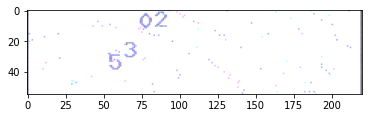

In [ ]:
username = 'defittri01'
password = 'Inazuma1'
matkul_kelas = [['TKSS213201',2],  ['TKSS213106',2]]

auto_KRS = auto_KRS()
auto_KRS.login(username, password)
auto_KRS.display_login_capt()


In [ ]:
auto_KRS.solve_login_capt()
auto_KRS.open_KRS_page()
# auto_KRS(matkul_kelas)

solve captcha: 5302


In [ ]:
auto_KRS.save_screenshot('simaster.png')

In [ ]:
auto_KRS.close()


TypeError: ignored